# **This Respository Contains the Classification Code of Urdu Mnist data using Pytorch Pretrained Vgg16 and Resnet18 model.**

### Requirenment 
*   GPU or CPU 
*   Memory = 8GB min

Please download cropped_months folder data along with python notebbok file to run the code.

Data contains images of 12 months names written in Urdu language.We will try to classify each months image into its corresponding class using pretrained VGG16 and Resnet18 models.




# **Loading libraries**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import PIL

# **Loading data to Visualize it**
We load data from Cropped_months folder.As we have 12 months data and every months urdu name written images are placed in its corresponding month name.We load the data suing this script.

In [0]:
import glob
import os
classnames = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
imagelist = []
labellist = []

for i in range(len(classnames)):
  imagenames = []
  imagenames.extend(glob.glob(os.getcwd()+'/cropped_months/train/'+classnames[i]+"/*.png"))
  for name in imagenames:
    imagelist.append(cv2.imread(name))
    labellist.append(i)

Convert our imageslist into numpy array and display its shape. We see its shape is 6000 by image dimension.6000 is total number of training images we have in our data set.

In [0]:
imagelist = np.array(imagelist)
print(imagelist.shape)


(6000, 173, 263, 3)


### **Lets take a look how our Urdu Mnist Data looks like.**

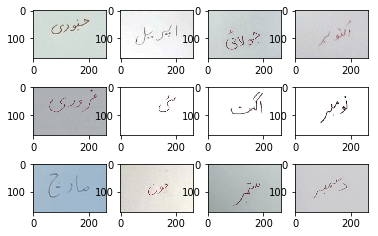

In [0]:
import urllib
f, axarr = plt.subplots(3, 4)
curr_row = 0
#index = 0
imageindex = 0
for index in range(12):
 
  
  a = imagelist[imageindex]
  # find the column by taking the current index modulo 3
  col = index % 3
  # plot on relevant subplot
  axarr[col,curr_row].imshow(a)
  imageindex = imageindex + 500
  if col == 2:
    # we have finished the current row, so increment row counter
    curr_row += 1

# **Data transformations and dataloder**
Now we make a data loader as we usually do in pytorch api. We use data loader to load traina nd test data and do normalization on images in batches. Data loaders are quite handy when data are in heavy size instead of loading all the images in RAM at once we give path to dataloaders to test and train directories and it loads data by itself in batches and also follow the directory structure to label that data.

In [0]:
batch_size = 64
data_dir = os.getcwd()+'/cropped_months/'
#Define transforms for the training data and testing data

data_transforms = {
    'train': transforms.Compose([transforms.Resize((224,224), interpolation=PIL.Image.BILINEAR),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize((224,224), interpolation=PIL.Image.BILINEAR),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We have applied certain normalization on our dataset.First we resize our image to fixed size 224*224 as required by Vgg16 model.then we apply intepolation while resizing as it will help keeping the aspect ratio of images.We apply data augmentation to our data set, it will help increasing the number of data samples during training and model will learn vaiations of data which is good.

# **Training Function**
Now we define our training function to train our model.

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=35):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_loss = []
    train_acc =[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                   
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)
              
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc,train_loss,val_acc_history,val_loss_history

# **VGG16 model initializer**
Now we declare VGG16 pretrained model inintializer in pytorch and freeze its convolutional layers.Because we only want to tune its last fully connected layers instead of training the whole model.

In [0]:

# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

#print(vgg16.classifier[6])
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer

#freezing convolutional layers
for param in vgg16.features.parameters():
    param.require_grad = False

#adding new layer according to our classes number
features.extend([nn.Linear(num_features, 12)])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 61.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now we declare our model optimizer and along with learning rate and loss function.As we are doing classification so cross entropy loss is suitable for this kind of problem.Afterwards we call train function to train the model.We just train our model to train at only 5 epochs.We will see that model will generate train test accuracy close to 99% in just 5 epochs.As VGG16 features are very good at transfer learning.

In [0]:
num_epochs = 5
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)



model_vgg, train_acc,train_loss,val_acc,val_loss = train_model(vgg16, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
torch.save(model_vgg.state_dict(), os.getcwd()+'/vgg16_2model.pth')

Epoch 0/4
----------
train Loss: 0.0005 Acc: 0.9907
test Loss: 0.0004 Acc: 0.9924

Epoch 1/4
----------
train Loss: 0.0003 Acc: 0.9948
test Loss: 0.0003 Acc: 0.9903

Epoch 2/4
----------
train Loss: 0.0002 Acc: 0.9955
test Loss: 0.0004 Acc: 0.9889

Epoch 3/4
----------
train Loss: 0.0002 Acc: 0.9945
test Loss: 0.0003 Acc: 0.9931

Epoch 4/4
----------
train Loss: 0.0002 Acc: 0.9963
test Loss: 0.0007 Acc: 0.9875

Training complete in 14m 44s
Best val Acc: 0.993056


In [0]:
a = []
a.append(train_acc)
a.append(train_loss)
a.append(val_acc)
a.append(val_loss)
print(len(a))


4


We have already get around 99% accuracy using Vgg16 network but we want to test out data on resnet model as well.

# **Resnet Model Training**
Now we fine tune our resnet model and see if it performs better than VGG16 or not.As we know resnet is a very deep network and it requires more iterations to train its model layers.We train resnet18 on 50 iterations and compare its accuracy and loss on testing data with VGG16 accuracy and loss.

In [0]:
input_size = 224
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
  param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 12)
resnet

In [0]:
num_epochs = 50
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)



model_resnet, train_acc,train_loss,val_acc,val_loss = train_model(resnet, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
torch.save(model_resnet.state_dict(), os.getcwd()+'/resnet_model.pth')

Epoch 0/49
----------
train Loss: 0.0248 Acc: 0.1248
test Loss: 0.0245 Acc: 0.1840

Epoch 1/49
----------
train Loss: 0.0227 Acc: 0.2387
test Loss: 0.0229 Acc: 0.2451

Epoch 2/49
----------
train Loss: 0.0213 Acc: 0.3232
test Loss: 0.0213 Acc: 0.3278

Epoch 3/49
----------
train Loss: 0.0202 Acc: 0.3893
test Loss: 0.0203 Acc: 0.3569

Epoch 4/49
----------
train Loss: 0.0193 Acc: 0.4128
test Loss: 0.0194 Acc: 0.4035

Epoch 5/49
----------
train Loss: 0.0185 Acc: 0.4512
test Loss: 0.0188 Acc: 0.4118

Epoch 6/49
----------
train Loss: 0.0178 Acc: 0.4800
test Loss: 0.0181 Acc: 0.4347

Epoch 7/49
----------
train Loss: 0.0173 Acc: 0.4987
test Loss: 0.0177 Acc: 0.4424

Epoch 8/49
----------
train Loss: 0.0168 Acc: 0.4957
test Loss: 0.0171 Acc: 0.4743

Epoch 9/49
----------
train Loss: 0.0165 Acc: 0.5098
test Loss: 0.0167 Acc: 0.4667

Epoch 10/49
----------
train Loss: 0.0161 Acc: 0.5358
test Loss: 0.0165 Acc: 0.4667

Epoch 11/49
----------
train Loss: 0.0157 Acc: 0.5277
test Loss: 0.0162 Acc

In [0]:
import pickle
b.append(train_acc)
b.append(train_loss)
b.append(val_acc)
b.append(val_loss)


### **Comparison of accuracy and loss curve of resnet and vgg16**
We see that Vgg16 gives better accuracy even after just epochs and resnet needs more iteration to get better accuracy.

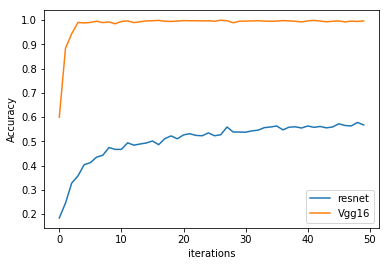

In [0]:
import matplotlib.pyplot as plt
plt.plot(a[2])
plt.plot(b[2])
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.legend(['resnet','Vgg16'])
plt.show()

## **Now we display ROC curve of our VGG16 model**

In [0]:
#Creating Only Test Dataloader to test data
batchsize = 100
data_dir = os.getcwd()+'/cropped_months/'
test_transform = transforms.Compose([transforms.Resize((224,224), interpolation=PIL.Image.BILINEAR),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

test_data = datasets.ImageFolder(data_dir+'test',transform = test_transform)
testloader = torch.utils.data.DataLoader(test_data,batch_size = batchsize,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Making Predictiong using Vgg16 model
model_vgg16.eval()
correct = 0 
total = 0
predictionlist = []
labellist = []
with torch.no_grad():
  for data in testloader:
    images, labels = data
    print(images.size())
    images, labels = images.to(device),labels.to(device)
    outputs = model_vgg16(images)
    
    print(outputs.size())
    predictionlist.append(outputs)
    labellist.append(labels)
    _,predicted = torch.max(outputs.data,1)
    total  += labels.size(0)
    correct += (predicted==labels).sum().item()
print("Accuracy of Test data: ",(correct/total)*100 )



#MAking predictions and labels into format suitable for ROC curve 
labels = labellist[0].cpu().numpy()
predictions = predictionlist[0].cpu().numpy()

for i in range(len(predictionlist)):
  if i != 0:
    templabel = labellist[i].cpu().numpy()
    labels = np.concatenate((labels,templabel),axis = 0)
    tempprediction = predictionlist[i].cpu().numpy()
    
    predictions = np.concatenate((predictions,tempprediction),axis = 0)
print(labels.shape)
print(predictions.shape)

y_onehot = labels
y_onehot = (np.arange(12) == y_onehot[:,None]).astype(np.float32)
#y_onehot = torch.from_numpy(y_onehot)
prediction2 = predictions
 
pred = np.zeros_like(prediction2)
pred[np.arange(len(prediction2)), prediction2.argmax(1)] = 1

### **Change index variable value to class number for ROc curve of that corresponding month class**
As we have set index 11 so we will get November months ROC curve

Accuracy of December class:  0.99


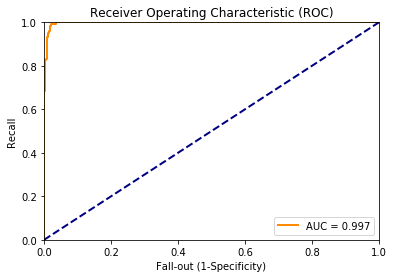

In [0]:
index=11
classnames = ['January','February','March','April','May','June','July','August','September','October','November','December']
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing

acc_NN = accuracy_score(y_onehot[:,index], pred[:,index])
print('Accuracy of '+classnames[index] +' class: ', round(acc_NN,2))
 
# #Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_onehot[:,index], prediction2[:,index])
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, color='darkorange',lw=2, label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], color="navy",lw = 2,linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.savefig('books_read.png')
plt.show()


We get a very high ROC value which means our model is doing extremely good in seperating diffferent class data.